# PPO with CNN - Features 

Getting some data:

In [136]:
import numpy as np
import yfinance as yf
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import math

In [138]:
tickers = ["AAPL","MSFT","GOOGL","META","AMZN","TSLA","NVDA"]

data = {}
for t in tickers:
    df = yf.download(t, start="2020-01-01", end="2023-01-01").copy()
    closes = df["Close"].astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    norm = (closes - mu) / sigma

    # Features and their windows are the exact same as the supervised learning 
    # EMA (5‑day)
    ema = closes.ewm(span=5, adjust=False).mean().astype(np.float32)

    # RSI (14‑day)
    delta = closes.diff()
    gain  = delta.clip(lower=0).rolling(14).mean()
    loss  = -delta.clip(upper=0).rolling(14).mean()
    rs    = gain / loss
    rsi   = (100 - 100/(1 + rs)).astype(np.float32)

    # MACD (12‑26)
    ema12 = closes.ewm(span=12, adjust=False).mean()
    ema26 = closes.ewm(span=26, adjust=False).mean()
    macd  = (ema12 - ema26).astype(np.float32)

    # Bollinger Bands (20‑day)
    mbb    = closes.rolling(20).mean()
    mbb_sd = closes.rolling(20).std()
    bb_upper = (mbb + 2*mbb_sd).astype(np.float32)
    bb_lower = (mbb - 2*mbb_sd).astype(np.float32)

    data[t] = {
        "dates":      df.index,
        "raw":        closes.values,
        "norm":       norm.values,
        "ema":        ema.values,
        "rsi":        rsi.values,
        "macd":       macd.values,
        "bb_upper":   bb_upper.values,
        "bb_lower":   bb_lower.values,
    }

raw_prices =    {t: data[t]["raw"]      for t in tickers}
normalized_prices = {t: data[t]["norm"]      for t in tickers}

# dropping any Nan values
for t in tickers:
    # stacking feature columns to detect any NaNs per row
    feat_stack = np.column_stack([
        data[t]["norm"],
        data[t]["ema"],
        data[t]["rsi"],
        data[t]["macd"],
        data[t]["bb_upper"],
        data[t]["bb_lower"],
    ])
    valid_rows = ~np.isnan(feat_stack).any(axis=1)
    start_idx = np.argmax(valid_rows)

    data[t]["dates"]    = data[t]["dates"][start_idx:]
    data[t]["raw"]      = data[t]["raw"][start_idx:]
    data[t]["norm"]     = data[t]["norm"][start_idx:]
    data[t]["ema"]      = data[t]["ema"][start_idx:]
    data[t]["rsi"]      = data[t]["rsi"][start_idx:]
    data[t]["macd"]     = data[t]["macd"][start_idx:]
    data[t]["bb_upper"] = data[t]["bb_upper"][start_idx:]
    data[t]["bb_lower"] = data[t]["bb_lower"][start_idx:]


for t in tickers:
    for feat in ["ema", "rsi", "macd", "bb_upper", "bb_lower"]:
        arr = data[t][feat]
        mu, sigma = arr.mean(), arr.std()
        # overwrite with z‑score normalization
        data[t][feat] = (arr - mu) / sigma

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### PPO for multiple stocks

In [266]:
state_dim   = 5  # window size 
action_dim  = 1   # how many features we have 
hidden_dim  = 64  # hidden layer size 
feat_dim    = 6
lr          = 3e-4
gamma       = 0.99
lam         = 0.95
clip_eps    = 0.2
epochs      = 500
batch_size  = 64
l2_lambda   = 1e-4

# build multi‐stock timeseries states with all 6 features
state_window = state_dim
states, next_states, rewards, dones = [], [], [], []

num_days = len(data[tickers[0]]["norm"]) - state_window - 1  # get size from full feature set

for day in range(num_days):
    s_day, ns_day, r_day = [], [], []

    for t in tickers:
        # stack all 6 features (norm, ema, rsi, macd, bb_upper, bb_lower)
        features = np.column_stack([
            data[t]["norm"],
            data[t]["ema"],
            data[t]["rsi"],
            data[t]["macd"],
            data[t]["bb_upper"],
            data[t]["bb_lower"],
        ])

        s_feat = features[day:day + state_window]            # shape: (5, 6)
        ns_feat = features[day + 1:day + 1 + state_window]    # shape: (5, 6)
        reward = data[t]["norm"][day + state_window + 1] - data[t]["norm"][day + state_window]

        s_day.append(s_feat)
        ns_day.append(ns_feat)
        r_day.append(reward.item())

    states.append(s_day)
    next_states.append(ns_day)
    rewards.append(r_day)
    dones.append([0.0] * len(tickers))

# convert to tensors (shape: [days, stocks, 5, 6])
states = torch.tensor(np.array(states), dtype=torch.float32)
next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
dones = torch.tensor(np.array(dones), dtype=torch.float32)

class RiskyCNNPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, feat_dim):
        super().__init__()
        self.state_dim = state_dim
        self.feat_dim = feat_dim

        # CNN expects shape (B, C=feat_dim, L=state_dim)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=feat_dim, out_channels=128, kernel_size=2),
            nn.SiLU(),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2),
            nn.SiLU(),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2),
            nn.SiLU(),
            nn.Flatten()
        )

        # Output size after 3 conv layers with kernel_size=2
        conv_out_size = (state_dim - 3) * 32  # adjusted for 3 conv layers each reducing L by 1

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            
            nn.Linear(128, action_dim),
            nn.Tanh()
        )

        self.value_head = nn.Linear(conv_out_size, 1)
        self.log_std = nn.Parameter(torch.ones(action_dim) * -1)  # std ≈ exp(-0.5) ≈ 0.6


    def forward(self, x):
        B = x.size(0)
        x = x.view(B, self.feat_dim, self.state_dim)  # (B, C=6, L=5)
        x_conv = self.conv(x)
        return self.fc(x_conv), self.value_head(x_conv)

# instantiate & optimiser
model = RiskyCNNPolicy(state_dim=state_dim, action_dim=action_dim, feat_dim=feat_dim)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=l2_lambda)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2_lambda)

def get_action(state, model):
    mean, _ = model(state)
    std = model.log_std.exp()
    dist = torch.distributions.Normal(mean, std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(axis=-1)
    return action, log_prob

with torch.no_grad():
    all_actions   = []
    all_log_probs = []
    all_values    = []

    for day in range(len(states)):            # 1) loop over days
        for stock in range(states.size(1)):  # 2) inner loop over 5 stocks
            s = states[day, stock].unsqueeze(0)  # shape (1, 5, 6)
            a, lp = get_action(s, model)  
            _, v  = model(s)


            all_actions  .append(a)
            all_log_probs.append(lp)
            all_values   .append(v)

    # bootstrap final values for each stock
    for stock in range(next_states.size(1)):
        s_final = next_states[-1, stock].view(1, -1)
        all_values.append(model(s_final)[1])  # take only value

# reshape into tensors
actions   = torch.cat(all_actions).view(len(states), -1, action_dim)
log_probs = torch.stack(all_log_probs).view(len(states), -1)
values    = torch.stack(all_values).view(len(states)+1, states.size(1))

# GAE calculation
advantages = torch.zeros_like(rewards)
for stock in range(states.size(1)):
    last_adv = 0
    for t in reversed(range(len(states))):
        delta    = rewards[t,stock] \
                   + gamma * values[t+1,stock] * (1 - dones[t,stock]) \
                   - values[t,stock]
        last_adv = delta + gamma * lam * (1 - dones[t,stock]) * last_adv
        advantages[t,stock] = last_adv
returns = advantages + values[:-1]

# flatten transitions for PPO
flat_states = states.view(-1, state_dim * feat_dim)
flat_actions = actions.view(-1, action_dim)
flat_lp_old  = log_probs.view(-1)
flat_ret     = returns.view(-1)
flat_adv     = advantages.view(-1)

# compute number of mini‑batches per epoch
n_trans   = flat_states.size(0)

n_batches = math.ceil(n_trans / batch_size)

actor_loss_hist = []
logprob_hist = []

# PPO training
for epoch in range(epochs):
    perm = torch.randperm(n_trans)
    epoch_actor_loss = 0.0
    epoch_logprob_sum = 0.0
    total_samples = 0
    for batch_idx, start in enumerate(range(0, n_trans, batch_size), start=1):
        idx          = perm[start:start+batch_size]
        state_batch  = flat_states[idx]
        action_batch = flat_actions[idx].unsqueeze(1)
        old_logps_b  = flat_lp_old[idx].detach()
        return_batch = flat_ret[idx].detach()
        adv_batch    = flat_adv[idx].detach()

        # actor
        mean, _ = model(state_batch)
        std = model.log_std.exp()
        dist = torch.distributions.Normal(mean, std)
        new_lps = dist.log_prob(action_batch).sum(axis=-1)

        ratio    = (new_lps - old_logps_b).exp()
        clipped  = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
        actor_loss = -torch.min(ratio * adv_batch, clipped).mean()

        # critic
        _, value_pred = model(state_batch)
        value_pred = value_pred.squeeze(-1)

        critic_loss = F.mse_loss(value_pred, return_batch)

        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_actor_loss += actor_loss.item()
        epoch_logprob_sum += new_lps.sum().item()
        total_samples += new_lps.size(0)

        # per‑batch print
        print(f"  Epoch {epoch+1}, Batch {batch_idx}/{n_batches} → Batch Loss: {loss.item():.4f}")

    actor_loss_hist.append(epoch_actor_loss / n_batches)
    logprob_hist.append(epoch_logprob_sum / total_samples)

    print(f"*** Finished Epoch {epoch+1}/{epochs}: last batch loss {loss.item():.4f} ***")


  Epoch 1, Batch 1/80 → Batch Loss: 0.1351
  Epoch 1, Batch 2/80 → Batch Loss: 0.1060
  Epoch 1, Batch 3/80 → Batch Loss: 0.2252
  Epoch 1, Batch 4/80 → Batch Loss: 0.0521
  Epoch 1, Batch 5/80 → Batch Loss: 0.1007
  Epoch 1, Batch 6/80 → Batch Loss: 0.4977
  Epoch 1, Batch 7/80 → Batch Loss: 0.0955
  Epoch 1, Batch 8/80 → Batch Loss: 0.1147
  Epoch 1, Batch 9/80 → Batch Loss: 0.4035
  Epoch 1, Batch 10/80 → Batch Loss: 0.0121
  Epoch 1, Batch 11/80 → Batch Loss: 0.0722
  Epoch 1, Batch 12/80 → Batch Loss: 0.1888
  Epoch 1, Batch 13/80 → Batch Loss: 0.1905
  Epoch 1, Batch 14/80 → Batch Loss: 0.1179
  Epoch 1, Batch 15/80 → Batch Loss: 0.0269
  Epoch 1, Batch 16/80 → Batch Loss: 0.0970
  Epoch 1, Batch 17/80 → Batch Loss: 0.0798
  Epoch 1, Batch 18/80 → Batch Loss: 0.1299
  Epoch 1, Batch 19/80 → Batch Loss: 0.6947
  Epoch 1, Batch 20/80 → Batch Loss: 0.0110
  Epoch 1, Batch 21/80 → Batch Loss: 0.1496
  Epoch 1, Batch 22/80 → Batch Loss: 0.0636
  Epoch 1, Batch 23/80 → Batch Loss: 0.08

In [179]:
model.eval()
torch.save(model.state_dict(), "model_cnn_feature_3.pth")


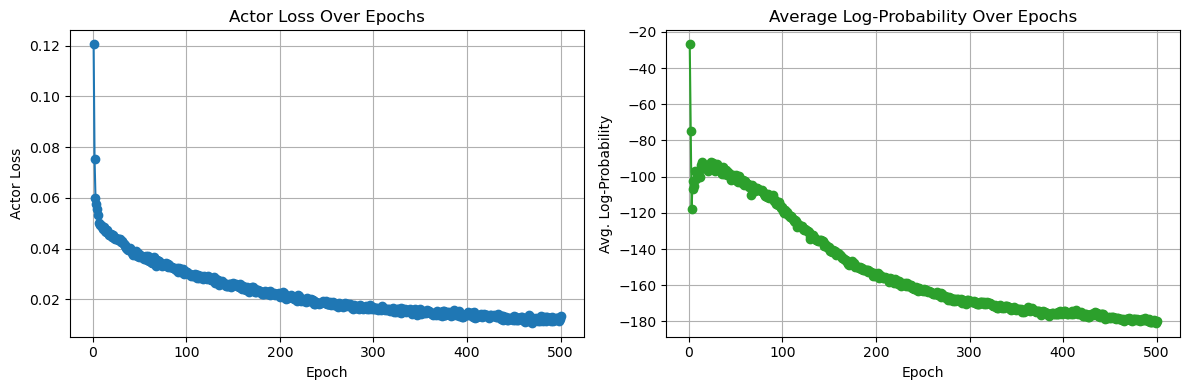

In [268]:
# Plot results after training
epochs_range = list(range(1, len(actor_loss_hist)+1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# 5.3.1 Actor Loss Over Epochs
ax1.plot(epochs_range, actor_loss_hist, marker='o')
ax1.set_title("Actor Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Actor Loss")
ax1.grid(True)

# 5.3.3 Log-Probability of Actions
ax2.plot(epochs_range, logprob_hist, marker='o', color='tab:green')
ax2.set_title("Average Log-Probability Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Avg. Log-Probability")
ax2.grid(True)

plt.tight_layout()
plt.savefig("CNN_features_actor_loss_and_logprob4.png", dpi=600)
plt.show()


### Trading Environment 

In [182]:
class MultiStockEnvironment:
    def __init__(self, data, window_size, initial_cash=10000):
        self.data = data
        self.window_size = window_size
        self.initial_cash = float(initial_cash)
        self.tickers = list(data.keys())
        self.reset()

    def reset(self):
        self.t = 0
        self.cash = self.initial_cash
        self.holdings = {t: 0.0 for t in self.tickers}
        self.portfolio_values = [self.initial_cash]
        self.done = False

        return {
            t: np.column_stack([
                self.data[t]["norm"],
                self.data[t]["ema"],
                self.data[t]["rsi"],
                self.data[t]["macd"],
                self.data[t]["bb_upper"],
                self.data[t]["bb_lower"],
            ])[0:self.window_size]
            for t in self.tickers
        }

    def step(self, actions):
        # Liquidate negatives
        freed_cash = 0.0
        for t in self.tickers:
            if actions[t] < 0 and self.holdings[t] > 0:
                price = self.data[t]["raw"][self.t + self.window_size].item()
                freed_cash += self.holdings[t] * price
                self.holdings[t] = 0.0
        self.cash += freed_cash

        # Allocate positives
        pos_actions = {t: actions[t] for t in self.tickers if actions[t] > 0}
        total_pos = sum(pos_actions.values())
        if total_pos > 0 and self.cash > 0:
            for t, a in pos_actions.items():
                weight = a / total_pos
                price = self.data[t]["raw"][self.t + self.window_size].item()
                buy_amount = self.cash * weight
                self.holdings[t] += buy_amount / price
            self.cash = 0.0

        # Compute portfolio value
        pv = self.cash
        for t in self.tickers:
            price = self.data[t]["raw"][self.t + self.window_size].item()
            pv += self.holdings[t] * price
        self.portfolio_values.append(pv)

        # Advance time
        self.t += 1
        if self.t + self.window_size >= len(self.data[self.tickers[0]]["norm"]):
            self.done = True

        # Next state
        next_states = None
        if not self.done:
            next_states = {
                t: np.column_stack([
                    self.data[t]["norm"],
                    self.data[t]["ema"],
                    self.data[t]["rsi"],
                    self.data[t]["macd"],
                    self.data[t]["bb_upper"],
                    self.data[t]["bb_lower"],
                ])[self.t:self.t + self.window_size]
                for t in self.tickers
            }

        return next_states, pv, self.done, {}


### buy and hold

In [185]:
class BuyAndHoldEnvironment:
    def __init__(self, raw_prices, initial_cash=10000):
        self.raw_prices = raw_prices
        self.initial_cash = initial_cash
        self.portfolio_values = []

    def run(self, start_index=10):
        # stack into shape (T,5)
        prices = np.stack([self.raw_prices[t] for t in tickers], axis=1)
        # equal allocation
        alloc = self.initial_cash / len(tickers)
        init_p = prices[start_index]            # [5,]
        shares = alloc / init_p                 # [5,]
        # build PV curve
        for p in prices[start_index+1:]:
            self.portfolio_values.append((shares * p).sum())

### Simulate Agent with the trained MLP once 

In [188]:
env = MultiStockEnvironment(data, window_size=state_dim)
state_dict = env.reset()

day = 0
print("Starting multi-stock simulation...\n")

while not env.done:
    actions = {}
    trades = {}

    for t in tickers:
        win = state_dict[t]  # shape: (5, 6), already normalized
        st = torch.tensor(win, dtype=torch.float32).view(1, -1)  # flatten to (1, 30)

        a_tensor, _ = get_action(st, model)
        a_val = a_tensor.item()
        actions[t] = a_val

        if a_val > 0 and env.holdings[t] == 0:
            trades[t] = "BUY"
        elif a_val < 0 and env.holdings[t] > 0:
            trades[t] = "SELL"
        else:
            trades[t] = "HOLD"

    # Step the environment
    next_states, port_val, done, _ = env.step(actions)

    # Log values
    cash = float(env.cash)
    prices = {t: float(data[t]["raw"][day + state_dim]) for t in tickers}
    held = {t: float(env.holdings[t]) for t in tickers}

    print(f"Day {day}: Cash = {cash:.2f}, Portfolio = {port_val:.2f}")
    for t in tickers:
        print(f"  {t:>6s} | Price = {prices[t]:6.2f} | "
              f"Action = {actions[t]:6.4f} | Trade = {trades[t]:>4s} | "
              f"Held = {held[t]:6.4f}")
    print("-" * 60)

    state_dict = next_states
    day += 1

print(f"\nDone. Final portfolio value: {env.portfolio_values[-1]:.2f}")


Starting multi-stock simulation...

Day 0: Cash = 0.00, Portfolio = 10000.00
    AAPL | Price =  78.73 | Action = 0.0010 | Trade =  BUY | Held = 0.0356
    MSFT | Price = 175.29 | Action = 0.2206 | Trade =  BUY | Held = 3.4670
   GOOGL | Price =  73.45 | Action = -1.0800 | Trade = HOLD | Held = 0.0000
    META | Price = 209.86 | Action = 1.7931 | Trade =  BUY | Held = 23.5406
    AMZN | Price = 102.51 | Action = -0.5802 | Trade = HOLD | Held = 0.0000
    TSLA | Price =  49.93 | Action = 1.6148 | Trade =  BUY | Held = 89.1081
    NVDA | Price =   6.33 | Action = -0.1639 | Trade = HOLD | Held = 0.0000
------------------------------------------------------------
Day 1: Cash = 0.00, Portfolio = 10030.21
    AAPL | Price =  77.66 | Action = -2.3537 | Trade = SELL | Held = 0.0000
    MSFT | Price = 175.54 | Action = 1.8164 | Trade = HOLD | Held = 3.4726
   GOOGL | Price =  73.60 | Action = -2.1266 | Trade = HOLD | Held = 0.0000
    META | Price = 211.33 | Action = 0.3306 | Trade = HOLD | Hel

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_3692/1306100077.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices = {t: float(data[t]["raw"][day + state_dim]) for t in tickers}


Day 31: Cash = 0.00, Portfolio = 8197.88
    AAPL | Price =  54.45 | Action = -0.0176 | Trade = HOLD | Held = 0.0000
    MSFT | Price = 130.16 | Action = 1.3443 | Trade =  BUY | Held = 62.3921
   GOOGL | Price =  52.46 | Action = -0.2580 | Trade = HOLD | Held = 0.0000
    META | Price = 147.41 | Action = 0.0128 | Trade =  BUY | Held = 0.5230
    AMZN | Price =  95.14 | Action = -1.3262 | Trade = SELL | Held = 0.0000
    TSLA | Price =  28.95 | Action = -1.3010 | Trade = HOLD | Held = 0.0000
    NVDA | Price =   5.30 | Action = -0.1284 | Trade = HOLD | Held = 0.0000
------------------------------------------------------------
Day 32: Cash = 0.00, Portfolio = 8942.72
    AAPL | Price =  59.91 | Action = -0.6974 | Trade = HOLD | Held = 0.0000
    MSFT | Price = 141.99 | Action = -0.0887 | Trade = SELL | Held = 0.0000
   GOOGL | Price =  56.23 | Action = 1.6767 | Trade =  BUY | Held = 118.7592
    META | Price = 160.22 | Action = -2.0190 | Trade = SELL | Held = 0.0000
    AMZN | Price =  9

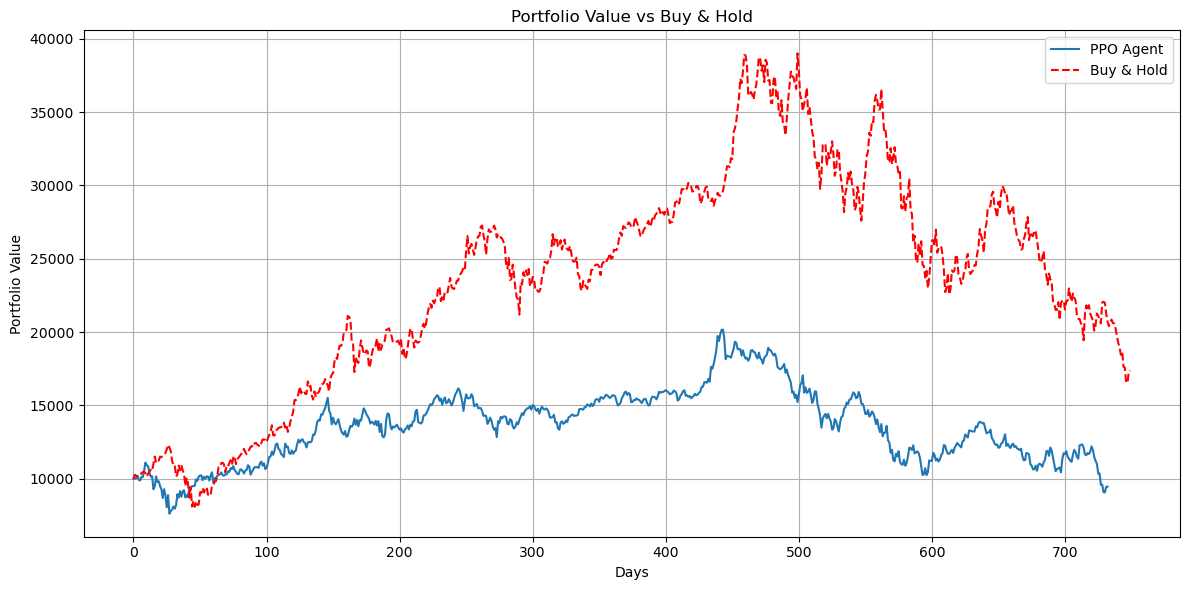


Final Results:
PPO final portfolio:       9455.88
Buy & Hold final portfolio:17379.21


In [190]:
bh_env = BuyAndHoldEnvironment(raw_prices)
bh_env.run(start_index=state_dim)

plt.figure(figsize=(12, 6))
plt.plot(env.portfolio_values, label='PPO Agent')
plt.plot(bh_env.portfolio_values, 'r--', label='Buy & Hold')
plt.title('Portfolio Value vs Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(f"PPO final portfolio:       {env.portfolio_values[-1]:.2f}")
print(f"Buy & Hold final portfolio:{bh_env.portfolio_values[-1]:.2f}")


### Run the Environment 50 times to get an average on how the MLP is performing

Running PPO agent simulations with CNN (Features)...

Run  1/200 → Final Portfolio Value: 19228.69
Run  2/200 → Final Portfolio Value: 7600.87
Run  3/200 → Final Portfolio Value: 15545.88
Run  4/200 → Final Portfolio Value: 12914.76
Run  5/200 → Final Portfolio Value: 15519.17
Run  6/200 → Final Portfolio Value: 13476.77
Run  7/200 → Final Portfolio Value: 17969.87
Run  8/200 → Final Portfolio Value: 10454.27
Run  9/200 → Final Portfolio Value: 21067.86
Run 10/200 → Final Portfolio Value: 12417.91
Run 11/200 → Final Portfolio Value: 18349.68
Run 12/200 → Final Portfolio Value: 19773.67
Run 13/200 → Final Portfolio Value: 12540.32
Run 14/200 → Final Portfolio Value: 9813.17
Run 15/200 → Final Portfolio Value: 7724.78
Run 16/200 → Final Portfolio Value: 8404.65
Run 17/200 → Final Portfolio Value: 13391.14
Run 18/200 → Final Portfolio Value: 9983.18
Run 19/200 → Final Portfolio Value: 20761.03
Run 20/200 → Final Portfolio Value: 27083.61
Run 21/200 → Final Portfolio Value: 8629.37
Run 22/

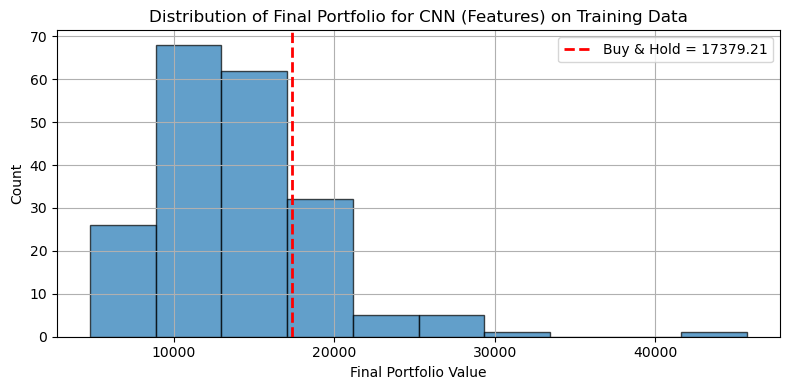

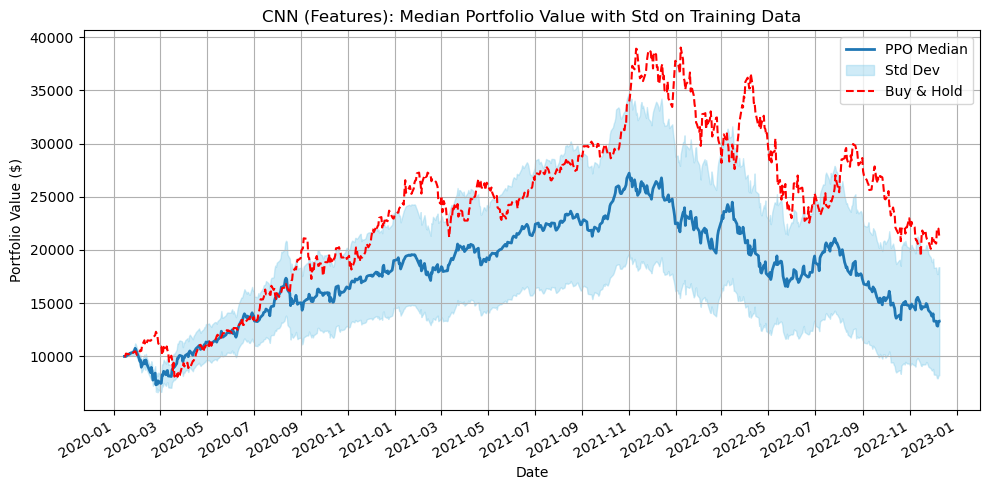

In [216]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch
import os

# === Load Buy & Hold ===
with open("buyhold_2020_2023.pkl", "rb") as f:
    bh_data = pickle.load(f)

bh_curve = bh_data["curve"]
bh_dates = pd.to_datetime(bh_data["dates"])
buy_hold_value = bh_curve[-1]
initial_cash = bh_curve[0]

# === PPO evaluation (CNN with features) ===
n_runs = 200
final_portfolios = []
ppo_trajectories = []

print("Running PPO agent simulations with CNN (Features)...\n")

for run in range(n_runs):
    env = MultiStockEnvironment(data, window_size=state_dim)
    state_dict = env.reset()
    done = False
    trajectory = [env.initial_cash]

    while not done:
        actions = {}
        for t in tickers:
            win = state_dict[t]  # shape (5, 6), already normalized
            st = torch.tensor(win, dtype=torch.float32).view(1, -1)
            a_val = get_action(st, model)[0].item()
            actions[t] = a_val

        state_dict, pv, done, _ = env.step(actions)
        trajectory.append(pv)

    final_value = trajectory[-1]
    final_portfolios.append(final_value)
    ppo_trajectories.append(trajectory)
    print(f"Run {run+1:2d}/{n_runs} → Final Portfolio Value: {final_value:.2f}")

# === Save all results ===
pd.DataFrame(final_portfolios, columns=["final_portfolio_value"]).to_csv("CNN_Features/cnn_features_final_portfolios.csv", index=False)

max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last_val = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last_val] * (max_len - len(ppo_trajectories[i]))

pd.DataFrame(ppo_trajectories).T.to_csv("CNN_Features/cnn_features_all_trajectories.csv", index=False)

# === Summary statistics ===
mean_pf = np.mean(final_portfolios)
std_pf  = np.std(final_portfolios)
min_pf  = np.min(final_portfolios)
max_pf  = np.max(final_portfolios)

beats_bh = sum(fp > buy_hold_value for fp in final_portfolios)
beat_pct = beats_bh / n_runs * 100
loses_bh = n_runs - beats_bh

agent_returns = [(pf / initial_cash - 1) * 100 for pf in final_portfolios]
bh_return = (buy_hold_value / initial_cash - 1) * 100

print(f"\nOver {n_runs} runs → mean final portfolio = {mean_pf:.2f} ± {std_pf:.2f}")
print(f"min = {min_pf:.2f}, max = {max_pf:.2f}")
print(f"Buy & Hold final portfolio = {buy_hold_value:.2f}")
print(f"\nAgent beat Buy & Hold  : {beats_bh}/{n_runs} runs ({beat_pct:.1f}%)")
print(f"Agent lost to Buy&Hold : {loses_bh}/{n_runs} runs ({100 - beat_pct:.1f}%)")
print(f"\nAverage agent return   : {np.mean(agent_returns):.2f}% ± {np.std(agent_returns):.2f}%")
print(f"Buy & Hold return      : {bh_return:.2f}%")

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_portfolios, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(buy_hold_value, color='r', linestyle='--', linewidth=2,
            label=f'Buy & Hold = {buy_hold_value:.2f}')
plt.title("Distribution of Final Portfolio for CNN (Features) on Training Data")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("CNN_Features/cnn_features_histogram.png", dpi=600)
plt.show()

# === Median ± Std plot ===
ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve    = np.std(ppo_array, axis=0)

x_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]

# Truncate to shared length
min_len = min(len(x_dates), len(median_curve), len(bh_curve))
x_dates = x_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(x_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(x_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, bh_curve, 'r--', label='Buy & Hold')

plt.title("CNN (Features): Median Portfolio Value with Std on Training Data")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("CNN_Features/cnn_features_median_std.png", dpi=600)
plt.show()


### test on unseen data 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Running CNN (Multi-feature) on Unseen Data...

Run   1/20 → Final Value: 20017.69
Run   2/20 → Final Value: 22387.87
Run   3/20 → Final Value: 13551.24
Run   4/20 → Final Value: 13439.15
Run   5/20 → Final Value: 16321.10
Run   6/20 → Final Value: 14245.78
Run   7/20 → Final Value: 16107.21
Run   8/20 → Final Value: 16233.01
Run   9/20 → Final Value: 16736.66
Run  10/20 → Final Value: 13102.72
Run  11/20 → Final Value: 13801.97
Run  12/20 → Final Value: 14242.31
Run  13/20 → Final Value: 14400.68
Run  14/20 → Final Value: 14222.34
Run  15/20 → Final Value: 17726.29
Run  16/20 → Final Value: 15682.89
Run  17/20 → Final Value: 14939.90
Run  18/20 → Final Value: 15570.26
Run  19/20 → Final Value: 13773.48
Run  20/20 → Final Value: 14192.96

=== CNN Policy on Unseen Data (2023–2024) ===
Runs: 20
→ Final Portfolio: mean 15534.78 ± 2276.03
→ Min: 13102.72, Max: 22387.87
→ Buy & Hold Final Portfolio: 20393.83
→ PPO beats Buy & Hold in 1/20 runs (5.0%)

→ Avg Agent Return: 55.35% ± 22.76%
→ Bu

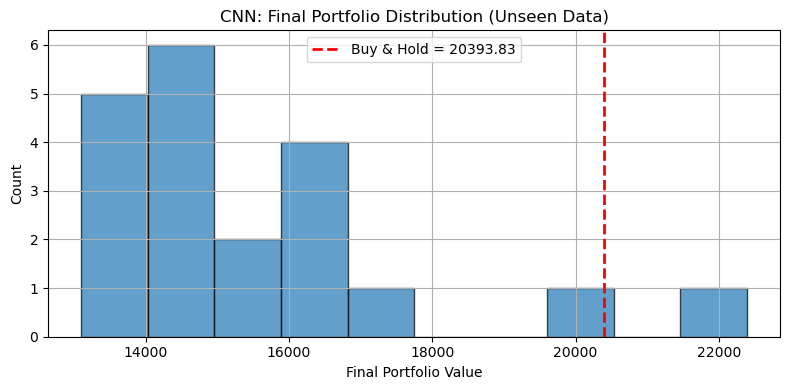

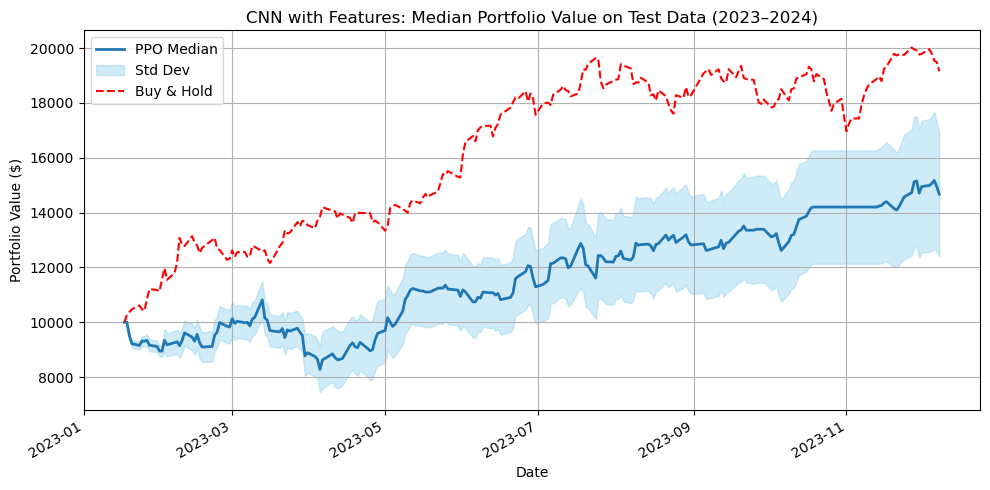

✓ Saved final portfolio values → CNN_Features/cnn_test_final_portfolios.csv
✓ Saved all PPO trajectories → CNN_Features/cnn_test_all_trajectories.csv


In [270]:
import pickle
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import os
import matplotlib.dates as mdates

tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
start, end = "2023-01-01", "2024-01-01"
state_dim = 5
initial_cash = 10000
n_runs = 20

# === Load Buy & Hold from saved file ===
with open("buyhold_2023_2024.pkl", "rb") as f:
    bh_data = pickle.load(f)
bh_curve = bh_data["curve"]
bh_final = bh_curve[-1]
bh_dates = pd.to_datetime(bh_data["dates"])

# === Load test data ===
data_test = {}
for t in tickers:
    df = yf.download(t, start=start, end=end).copy()
    closes = df["Close"].astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    norm = (closes - mu) / sigma

    ema = closes.ewm(span=5, adjust=False).mean().astype(np.float32)
    delta = closes.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / loss
    rsi = (100 - 100/(1 + rs)).astype(np.float32)

    ema12 = closes.ewm(span=12, adjust=False).mean()
    ema26 = closes.ewm(span=26, adjust=False).mean()
    macd = (ema12 - ema26).astype(np.float32)

    mbb = closes.rolling(20).mean()
    mbb_sd = closes.rolling(20).std()
    bb_upper = (mbb + 2*mbb_sd).astype(np.float32)
    bb_lower = (mbb - 2*mbb_sd).astype(np.float32)

    data_test[t] = {
        "dates": df.index,
        "raw": closes.values,
        "norm": norm.values,
        "ema": ema.values,
        "rsi": rsi.values,
        "macd": macd.values,
        "bb_upper": bb_upper.values,
        "bb_lower": bb_lower.values,
    }

# Clean + normalize
for t in tickers:
    feat_stack = np.column_stack([
        data_test[t]["norm"],
        data_test[t]["ema"],
        data_test[t]["rsi"],
        data_test[t]["macd"],
        data_test[t]["bb_upper"],
        data_test[t]["bb_lower"],
    ])
    valid_rows = ~np.isnan(feat_stack).any(axis=1)
    start_idx = np.argmax(valid_rows)

    for k in data_test[t]:
        data_test[t][k] = data_test[t][k][start_idx:]

    for feat in ["ema", "rsi", "macd", "bb_upper", "bb_lower"]:
        arr = data_test[t][feat]
        mu, sigma = arr.mean(), arr.std()
        data_test[t][feat] = (arr - mu) / sigma

# === PPO Evaluation ===
final_pf = []
ppo_trajectories = []

print("Running CNN (Multi-feature) on Unseen Data...\n")

for run in range(n_runs):
    env_test = MultiStockEnvironment(copy.deepcopy(data_test), window_size=state_dim, initial_cash=initial_cash)
    state_dict = env_test.reset()
    trajectory = [env_test.initial_cash]

    while not env_test.done:
        actions = {}
        for t in tickers:
            win = state_dict[t]
            st = torch.tensor(win, dtype=torch.float32).view(1, -1)
            a_tensor, _ = get_action(st, model)
            actions[t] = a_tensor.item()

        state_dict, port_val, done, _ = env_test.step(actions)
        trajectory.append(port_val)

    final_val = trajectory[-1]
    final_pf.append(final_val)
    ppo_trajectories.append(trajectory)
    print(f"Run {run+1:3d}/{n_runs} → Final Value: {final_val:.2f}")

# === Summary ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
min_pf = np.min(final_pf)
max_pf = np.max(final_pf)
beats = sum(p > bh_final for p in final_pf)
beat_pct = beats / n_runs * 100

agent_returns = [(pf / initial_cash - 1) * 100 for pf in final_pf]
bh_return = (bh_final / initial_cash - 1) * 100

print(f"\n=== CNN Policy on Unseen Data (2023–2024) ===")
print(f"Runs: {n_runs}")
print(f"→ Final Portfolio: mean {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Buy & Hold Final Portfolio: {bh_final:.2f}")
print(f"→ PPO beats Buy & Hold in {beats}/{n_runs} runs ({beat_pct:.1f}%)")
print(f"\n→ Avg Agent Return: {np.mean(agent_returns):.2f}% ± {np.std(agent_returns):.2f}%")
print(f"→ Buy & Hold Return: {bh_return:.2f}%")

# === Pad trajectories ===
max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last] * (max_len - len(ppo_trajectories[i]))

ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve = np.std(ppo_array, axis=0)


# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {bh_final:.2f}')
plt.title("CNN: Final Portfolio Distribution (Unseen Data)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("CNN_Features/UNSEEN_hist.png", dpi=600)
plt.show()

# === Median ± Std plot ===
plot_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]
min_len = min(len(plot_dates), len(median_curve), len(bh_curve))
plot_dates = plot_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(plot_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(plot_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(plot_dates, bh_curve, 'r--', label='Buy & Hold')

plt.title("CNN with Features: Median Portfolio Value on Test Data (2023–2024)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("CNN_Features/UNSEEN_median_std2.png", dpi=600)
plt.show()

# === Save CSVs ===
#pd.DataFrame({"final_portfolio_value": final_pf}).to_csv("CNN_Features/cnn_test_final_portfolios.csv", index=False)
#pd.DataFrame(ppo_trajectories).T.to_csv("CNN_Features/cnn_test_all_trajectories.csv", index=False)

print("Saved final portfolio values → CNN_Features/cnn_test_final_portfolios.csv")
print("Saved all PPO trajectories → CNN_Features/cnn_test_all_trajectories.csv")
